<a href="https://colab.research.google.com/github/w3t4nu5/deep-learning-1/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, BatchNormalization, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Model parameters
max_features = 20000  # vocabulary size
maxlen = 500        # sequence length for padding

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [5]:
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def build_and_train_model(model, x_train, y_train, x_test, y_test):

    initial_learning_rate = 0.001
    decay_steps = 100
    decay_rate = 0.96
    lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
    verbose=1
    )
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=40, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Building and training RNN Model...
Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 441ms/step - accuracy: 0.5035 - loss: 2.1228 - val_accuracy: 0.5062 - val_loss: 1.7470
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.5569 - loss: 1.7290 - val_accuracy: 0.5074 - val_loss: 2.2282
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 459ms/step - accuracy: 0.8557 - loss: 1.1671 - val_accuracy: 0.7158 - val_loss: 1.6718
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 427ms/step - accuracy: 0.9353 - loss: 0.8414 - val_accuracy: 0.7736 - val_loss: 1.0937
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.9639 - loss: 0.6459 - val_accuracy: 0.8794 - val_loss: 0.8636
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.9810 - loss: 0.5044 - val_accuracy: 0.8808 - val_loss: 0.8249
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 459ms/step - accuracy: 0.9880 - loss: 0.4116 - val_accuracy: 0.8708 - val_loss: 0.8471
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 456

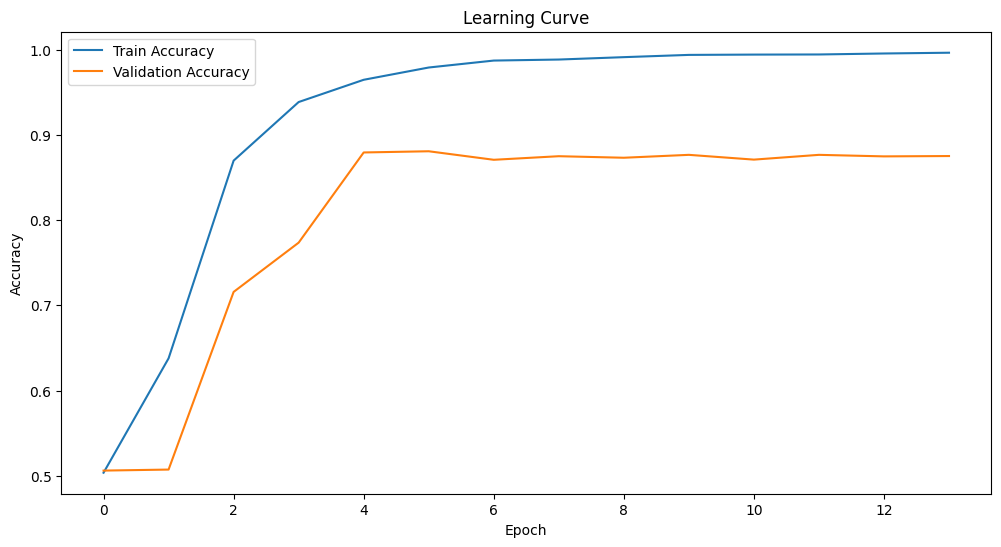

782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



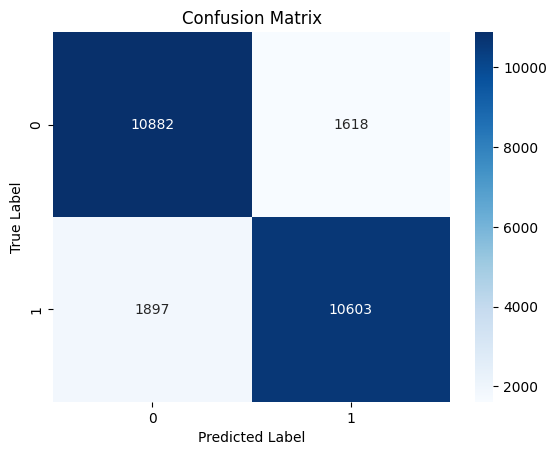


RNN Model training complete.


In [6]:
print("\nBuilding and training RNN Model...")
rnn_model = Sequential([
    Embedding(max_features, 256, input_shape=(maxlen,)),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

build_and_train_model(rnn_model, x_train, y_train, x_test, y_test)

print("\nRNN Model training complete.")